In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
df = pd.read_csv("../data/NaturalGasPrice/daily.csv")

In [3]:
df = df.dropna()

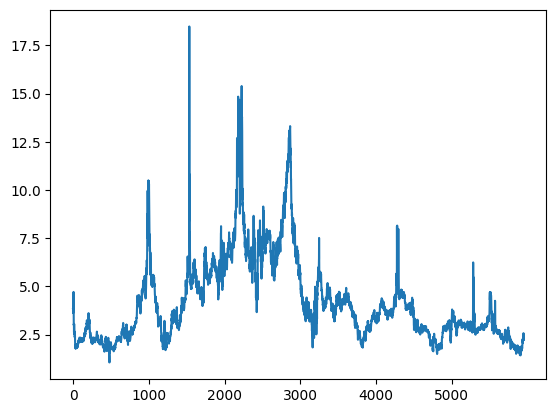

In [4]:
plt.plot(df['Price'])
plt.xticks(range(0, len(df['Price']), 1000))
plt.show()

In [5]:
y = df['Price'].values
x = np.arange(1, len(y), 1)

In [6]:
print(len(y))

5952


In [7]:
minm = y.min()
maxm = y.max()

y = (y - minm) / (maxm - minm)

In [8]:
Sequence_Length = 10

In [9]:
X = []
Y = []
for i in range(0, len(y) - Sequence_Length):
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[j + 1])

In [10]:
X = np.array(X)
Y = np.array(Y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.10,
    shuffle=False,
    stratify=None
)

In [12]:
class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

In [13]:
dataset = NGTimeSeries(x_train, y_train)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, shuffle=True, batch_size=128)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel,self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _status = self.rnn(x)
        output = output[:, -1, :]
        output = self.fc(torch.relu(output))
        return output

In [17]:
model = RNNModel().to(device)

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

In [19]:
loss_list = []

for i in range(epochs):
    i += 1
    for j, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, Sequence_Length, 1)
        optimizer.zero_grad()
        y_pred = model(data).reshape(-1)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()

    if i % 100 == 0:
        print(i, "th iteration : ", loss.item())

100 th iteration :  0.0009653037413954735
200 th iteration :  0.0005607182392850518
300 th iteration :  0.0003201793588232249
400 th iteration :  0.0002888647431973368
500 th iteration :  0.0001673724764259532
600 th iteration :  0.0002737470786087215
700 th iteration :  0.0004268204211257398
800 th iteration :  0.0001747409114614129
900 th iteration :  7.875463779782876e-05
1000 th iteration :  0.00011006554268533364
1100 th iteration :  0.0002667797380127013
1200 th iteration :  9.758459782460704e-05
1300 th iteration :  0.00019165151752531528
1400 th iteration :  9.673278691479936e-05
1500 th iteration :  0.00019549220451153815


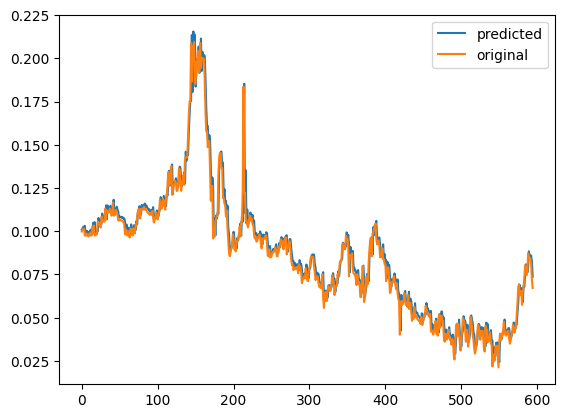

In [20]:
test_set = NGTimeSeries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,Sequence_Length,1).to(device)).view(-1)

plt.plot(test_pred.cpu().detach().numpy(),label='predicted')
plt.plot(test_set[:][1].view(-1),label='original')
plt.legend()
plt.show()